In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import normalize


import os
import pathlib
import sys
import matplotlib.pyplot as plt
from scipy import linalg


sys.path.append(os.path.join(pathlib.Path(os.getcwd()).parent))
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

from utils.bq_conn import bq_conn_file
# %%
bq_client = bq_conn_file(project_id="dsa-miad-365616")

In [ ]:
pd.options.display.max_columns = None

query = '''
SELECT
    *
FROM `Proyecto.DatosSecopI`
ORDER BY anno_cargue_secop DESC
'''
bq_client = bq_conn_file(project_id="dsa-miad-365616")
secop_I = bq_client.execute_query(query=query)
print(f"El número de filas del dataset: {secop_I.shape[0]}\nEl número de columnas del dataset: {secop_I.shape[1]}")
secop_I.head(5)





In [ ]:
secopI_filter = secop_I[
    ['id_modalidad', 'estado_del_proceso', 'id_objeto_a_contratar', 'tipo_de_contrato', 'departamento_ejecucion',
     'municipios_ejecucion_', 'cuantia_proceso', 'id_grupo',
     'id_familia', 'id_clase', 'plazo_de_ejec_del_contrato_', 'tiempo_adiciones_en_dias', 'dias_ejec_final_contrato']]

secopI_filter
secopI_filter.columns
base = secopI_filter
n = base.isna() == True
base = base.fillna(0)
base.info()


In [ ]:
# Codificación de las variables categoricas
base['estado_del_proceso'] = pd.factorize(base.estado_del_proceso)[0]
base['tipo_de_contrato'] = pd.factorize(base.tipo_de_contrato)[0]
base['departamento_ejecucion'] = pd.factorize(base.departamento_ejecucion)[0]
base['municipios_ejecucion_'] = pd.factorize(base.municipios_ejecucion_)[0]
base['id_grupo'] = pd.factorize(base.id_grupo)[0]
base['id_familia'] = pd.factorize(base.id_familia)[0]
base['id_clase'] = pd.factorize(base.id_clase)[0]
base['plazo_de_ejec_del_contrato_'] = pd.factorize(base.plazo_de_ejec_del_contrato_)[0]

In [ ]:
df = base
df.info()

In [ ]:
from sklearn.model_selection import train_test_split

y_total = df.loc[:, df.columns == "tiempo_adiciones_en_dias"]
X_total = df.loc[:, df.columns != "tiempo_adiciones_en_dias"]
y_total = y_total.reset_index(drop=True)

# Reparto de datos en train y test
y_totalf = y_total.tiempo_adiciones_en_dias.tolist()
X_train, X_test, y_train, y_test = train_test_split(X_total, y_totalf, test_size=0.33, random_state=1)


In [ ]:
import seaborn as sns
sns.heatmap(X_total[["id_modalidad", "id_objeto_a_contratar", "estado_del_proceso", "tipo_de_contrato", "departamento_ejecucion","municipios_ejecucion_","cuantia_proceso","id_grupo","id_familia", "id_clase","plazo_de_ejec_del_contrato_", "dias_ejec_final_contrato" ]].corr(), vmin=-1, vmax=1, annot=False)


In [ ]:
train_dataset = df.sample(frac=0.8,random_state=0)
test_dataset = df.drop(train_dataset.index)

In [ ]:
train_stats = train_dataset.describe()
train_stats.pop("dias_ejec_final_contrato")
train_stats = train_stats.transpose()
train_stats


In [ ]:
train_labels = train_dataset.pop('dias_ejec_final_contrato')
test_labels = test_dataset.pop('dias_ejec_final_contrato')

In [ ]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

In [189]:
def build_model ():
  model = keras.Sequential([
    layers.Dense(13, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dense(6, activation='linear'),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['r_square','mae', 'mse'])
  return model

In [190]:
model = build_model()

In [191]:
model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_44 (Dense)            (None, 13)                169       
                                                                 
 dense_45 (Dense)            (None, 6)                 84        
                                                                 
 dense_46 (Dense)            (None, 1)                 7         
                                                                 
Total params: 260 (1.02 KB)
Trainable params: 260 (1.02 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [192]:
train_data = np.asarray(normed_train_data).astype(np.float32)
test_data = np.asarray(normed_test_data).astype(np.float32)


In [193]:
example_batch = np.array(train_data[:])
example_result = model.predict(example_batch)
example_result

664/664 [==============================] - 0s 455us/step


array([[-2.2749965 ],
       [-0.63831735],
       [-1.9930212 ],
       ...,
       [-1.0514238 ],
       [ 0.02967399],
       [ 0.16591159]], dtype=float32)

In [194]:
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 100

from keras import backend as K
train_data = K.cast_to_floatx(train_data)
train_labels = K.cast_to_floatx(train_labels)

history = model.fit(
   train_data,
    train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])

TypeError: in user code:

    File "/Users/marioriveravargas/miniconda3/envs/proyecto_miad/bin/lib/python3.10/site-packages/keras/src/engine/training.py", line 1338, in train_function  *
        return step_function(self, iterator)
    File "/Users/marioriveravargas/miniconda3/envs/proyecto_miad/bin/lib/python3.10/site-packages/keras/src/engine/training.py", line 1322, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/marioriveravargas/miniconda3/envs/proyecto_miad/bin/lib/python3.10/site-packages/keras/src/engine/training.py", line 1303, in run_step  **
        outputs = model.train_step(data)
    File "/Users/marioriveravargas/miniconda3/envs/proyecto_miad/bin/lib/python3.10/site-packages/keras/src/engine/training.py", line 1085, in train_step
        return self.compute_metrics(x, y, y_pred, sample_weight)
    File "/Users/marioriveravargas/miniconda3/envs/proyecto_miad/bin/lib/python3.10/site-packages/keras/src/engine/training.py", line 1179, in compute_metrics
        self.compiled_metrics.update_state(y, y_pred, sample_weight)
    File "/Users/marioriveravargas/miniconda3/envs/proyecto_miad/bin/lib/python3.10/site-packages/keras/src/engine/compile_utils.py", line 605, in update_state
        metric_obj.update_state(y_t, y_p, sample_weight=mask)
    File "/Users/marioriveravargas/miniconda3/envs/proyecto_miad/bin/lib/python3.10/site-packages/keras/src/utils/metrics_utils.py", line 77, in decorated
        update_op = update_state_fn(*args, **kwargs)
    File "/Users/marioriveravargas/miniconda3/envs/proyecto_miad/bin/lib/python3.10/site-packages/keras/src/metrics/base_metric.py", line 140, in update_state_fn
        return ag_update_state(*args, **kwargs)
    File "/Users/marioriveravargas/miniconda3/envs/proyecto_miad/bin/lib/python3.10/site-packages/keras/src/metrics/base_metric.py", line 723, in update_state  **
        matches = ag_fn(y_true, y_pred, **self._fn_kwargs)

    TypeError: 'str' object is not callable


In [195]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
print(hist)

            loss        mae           mse      val_loss    val_mae   
0   28415.894531  74.557076  28415.894531  13410.435547  65.475189  \
1   23214.953125  67.795189  23214.953125  10090.941406  69.179489   
2   21916.507812  69.946724  21916.507812   9718.583984  69.293770   
3   21693.839844  69.453629  21693.839844   9640.004883  68.337006   
4   21767.927734  68.814346  21767.927734   9595.024414  68.080124   
..           ...        ...           ...           ...        ...   
95  23380.943359  66.822739  23380.943359   9314.510742  66.086578   
96  23437.478516  67.016327  23437.478516   9306.427734  65.617439   
97  23384.484375  66.866219  23384.484375   9306.983398  65.748459   
98  23295.167969  66.900894  23295.167969   9300.399414  65.758652   
99  23170.601562  66.961021  23170.601562   9301.790039  65.332382   

         val_mse  epoch  
0   13410.435547      0  
1   10090.941406      1  
2    9718.583984      2  
3    9640.004883      3  
4    9595.024414      4  
.. 

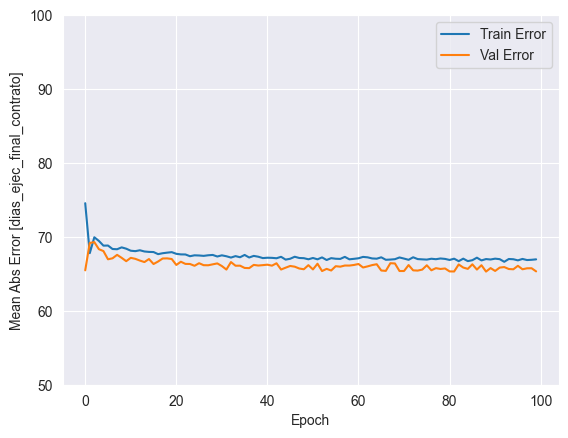

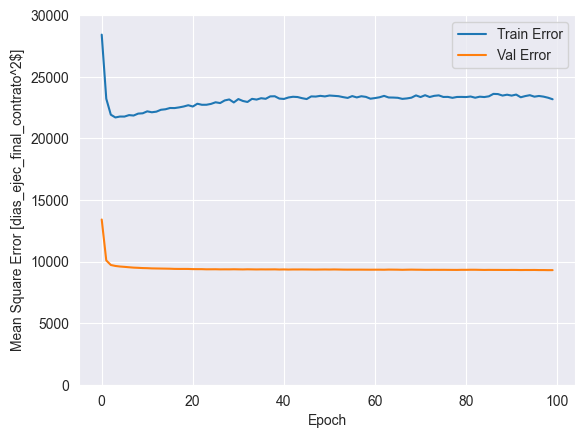

In [199]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [dias_ejec_final_contrato]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.ylim([50,100])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [dias_ejec_final_contrato^2$]')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.ylim([0,30000])
  plt.legend()
  plt.show()


plot_history(history)